# Analysis with XGBoost

In this botebook, I will analyze data 3 '3year.arff' using the Ensemble Method 'XGBoost'.

Since my business goal is identifying whether the company will bankrupt or not, I will focus on the 'precision' on my predictions. Besides 'precision' metric, I will also keep an eye on 'f1', 'AUC' and 'accuracy' values.  

## Load Libraries

In [1]:
# Import base libraries
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from functions import *

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will explore the models on data3. After determing the final model design, I will apply it on other datasets and compare te results.


In [2]:
# Load data
data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])
df3.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [3]:
df3.shape

(10503, 65)

In [4]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   10503 non-null  float64
 1   Attr2   10503 non-null  float64
 2   Attr3   10503 non-null  float64
 3   Attr4   10485 non-null  float64
 4   Attr5   10478 non-null  float64
 5   Attr6   10503 non-null  float64
 6   Attr7   10503 non-null  float64
 7   Attr8   10489 non-null  float64
 8   Attr9   10500 non-null  float64
 9   Attr10  10503 non-null  float64
 10  Attr11  10503 non-null  float64
 11  Attr12  10485 non-null  float64
 12  Attr13  10460 non-null  float64
 13  Attr14  10503 non-null  float64
 14  Attr15  10495 non-null  float64
 15  Attr16  10489 non-null  float64
 16  Attr17  10489 non-null  float64
 17  Attr18  10503 non-null  float64
 18  Attr19  10460 non-null  float64
 19  Attr20  10460 non-null  float64
 20  Attr21  9696 non-null   float64
 21  Attr22  10503 non-null  float64
 22

In [5]:
# Change label/class  type
df3['class'] = df3['class'].astype('int64')

## Pre-process

In [6]:
# Assign target and predictor

y = df3['class']
X = df3.drop('class', axis=1)

In [7]:
# Sepearate data into train and test splist

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8402, 64)
y_train shape =  (8402,)
X_test shape =  (2101, 64)
y_test shape =  (2101,)


In [8]:
# Scale/Normalize the predictor variables

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Baseline Model - XGBoost


In [11]:
# Instantiate, and fit XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42) #'logloss' is default, but specified to stop warning
xgb.fit(X_train, y_train)

print('Data3:\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.93      0.47      0.62       107

    accuracy                           0.97      2101
   macro avg       0.95      0.73      0.80      2101
weighted avg       0.97      0.97      0.97      2101



**Comments**

* According to testing data results, the model performance in identfying the non-bankruptcy companies (class 0) is very good. 
* However, the identification of the bankruptcy companies (class 1) is not as good.
* The class imbalance is probbaly the reason for the class 0/1 performance difference.
* There is a huge overfitting, especially on class 1 predictions.

### Class Imbalance

In [11]:
#Check Class Imbalance
df3['class'].value_counts(normalize=True)

0    0.952871
1    0.047129
Name: class, dtype: float64

In [12]:
# Explore scale_pos_weight

val_counts = df3['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

imbalance ratio: 20.21818181818182
sqrt of imbalance ratio: 4.496463256625347


In [10]:
#Treat Imbalance, scale_pos_weight = imbalance ratio

xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=20, random_state=42)
xgb.fit(X_train, y_train)

print('Data3, scale_pos_weight = imbalance ratio:\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, scale_pos_weight = imbalance ratio:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.83      0.50      0.62       107

    accuracy                           0.97      2101
   macro avg       0.90      0.74      0.80      2101
weighted avg       0.97      0.97      0.97      2101



In [12]:
#Treat Imbalance, scale_pos_weight = sqrt of imbalance ratio

xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=4.5, random_state=42)
xgb.fit(X_train, y_train)

print('Data3, Imbalance addressed, scale_pos_weight = 4.5 (sqrt of imbalance ratio):\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, Imbalance addressed, scale_pos_weight = 4.5 (sqrt of imbalance ratio):

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.95      0.52      0.67       107

    accuracy                           0.97      2101
   macro avg       0.96      0.76      0.83      2101
weighted avg       0.97      0.97      0.97      2101



,accuracy,precision,recall,f1,auc
Params,,,,,
scale_pos_weight=1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.971,0.926,0.467,0.621,0.941
scale_pos_weight=3 Train,1.000,1.000,1.000,1.000,1.000
Test,0.970,0.907,0.458,0.609,0.935
scale_pos_weight=4.5 Train,1.000,1.000,1.000,1.000,1.000
Test,0.974,0.949,0.523,0.675,0.935
scale_pos_weight=6 Train,1.000,1.000,1.000,1.000,1.000
Test,0.971,0.898,0.495,0.639,0.936
scale_pos_weight=10 Train,1.000,1.000,1.000,1.000,1.000


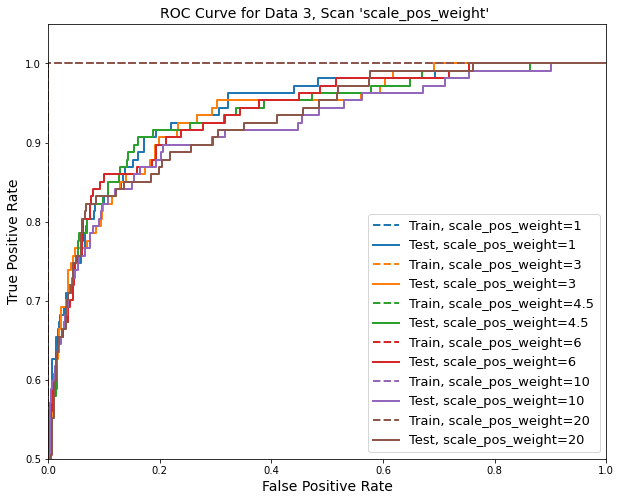

In [10]:
# Compare 'scale_pos_weight' values

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42
}

scanParam = 'scale_pos_weight'

scanList = [1, 3, 4.5, 6, 10, 20]
#scanList = [1, 4.5, 20]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments**
* Using 'scale_pos_weight' increased the model performance on testing data.
* I choose to use scale_pos_weight = 4.5 in my analysis, since it has the highest precision.
    * sqrt of imbalance ratio = 4.5
* Overfitting continues.

In [25]:
# Model 1: Baseline Model with selected scale_pos_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5
}

model_1 = XGBClassifier(**xgbParams)
model_1.fit(X_train, y_train)

print('Data3, Model 1:\n')
print('Training Data:\n', classification_report(y_train, model_1.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_1.predict(X_test)))

model_1.save_model('saved_model_history/xgb_model_1.json')

Data3, Model 1:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.95      0.52      0.67       107

    accuracy                           0.97      2101
   macro avg       0.96      0.76      0.83      2101
weighted avg       0.97      0.97      0.97      2101



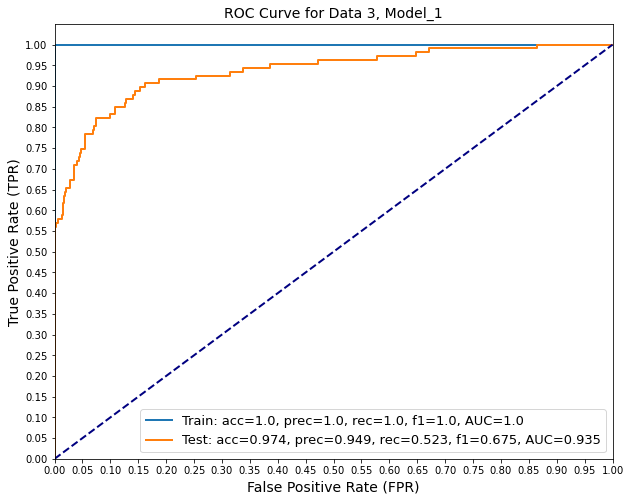

In [24]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, xgbParams, 'Model_1')

## Overfitting and Performance

The ovefitting looks a like a main issue at this point.

I will scan over several paramaters to see if overfitting can be decreased, while keeping the performance high.

In [17]:
model_1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,accuracy,precision,recall,f1,auc
Params,,,,,
max_depth=1 Train,0.953,0.485,0.454,0.469,0.916
Test,0.945,0.462,0.449,0.455,0.898
max_depth=2 Train,0.977,0.746,0.755,0.750,0.987
Test,0.961,0.635,0.570,0.601,0.936
max_depth=3 Train,0.996,0.936,0.979,0.957,1.000
Test,0.968,0.760,0.533,0.626,0.931
max_depth=4 Train,1.000,0.992,1.000,0.996,1.000
Test,0.970,0.824,0.523,0.640,0.936
max_depth=5 Train,1.000,1.000,1.000,1.000,1.000


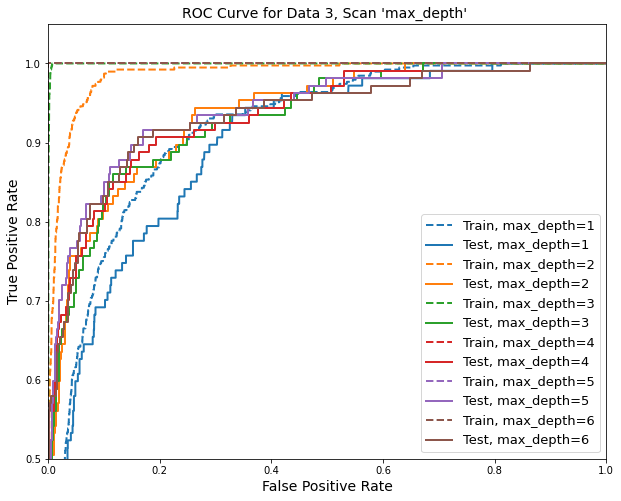

In [30]:
#Scan max_depth

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5
}

scanParam = 'max_depth'

scanList = [1, 2, 3, 4, 5, 6]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments of max_depth**

* The overfitting decreases as the the max_depth decreases.
* However, the model performance and precision also drops.
* The max_depth=2, 3, 4 are options
* I choose to use max_depth=3.

,accuracy,precision,recall,f1,auc
Params,,,,,
n_estimators=30 Train,0.974,0.732,0.688,0.709,0.980
Test,0.959,0.616,0.495,0.549,0.918
n_estimators=40 Train,0.979,0.796,0.742,0.768,0.988
Test,0.962,0.652,0.542,0.592,0.922
n_estimators=50 Train,0.983,0.825,0.802,0.813,0.993
Test,0.963,0.671,0.533,0.594,0.924
n_estimators=60 Train,0.986,0.854,0.843,0.848,0.996
Test,0.963,0.675,0.523,0.589,0.925
n_estimators=80 Train,0.992,0.908,0.920,0.914,0.999


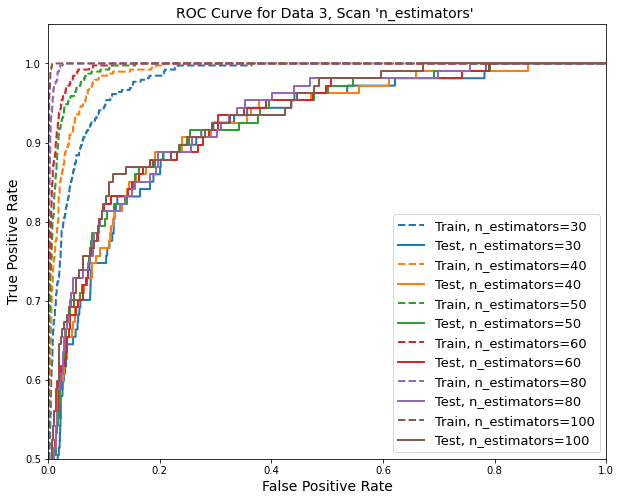

In [42]:
#Scan n_estimators

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3
}

scanParam = 'n_estimators'

scanList = [30, 40, 50, 60, 80, 100]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments of n_estimators**

* As n_estimators decrease, overfitting sligtly decreases.
* However, model preformance drops significantly
* Goop n_estimators are 50 and 100.
* I will keep n_estimators=100

,accuracy,precision,recall,f1,auc
Params,,,,,
colsample_bytree=0.5 Train,0.995,0.925,0.959,0.942,0.999
Test,0.968,0.741,0.561,0.638,0.931
colsample_bytree=0.6 Train,0.996,0.933,0.974,0.953,0.999
Test,0.969,0.759,0.561,0.645,0.931
colsample_bytree=0.7 Train,0.995,0.931,0.969,0.949,1.000
Test,0.970,0.787,0.551,0.648,0.936
colsample_bytree=0.8 Train,0.995,0.942,0.956,0.949,1.000
Test,0.969,0.784,0.542,0.641,0.929
colsample_bytree=0.9 Train,0.995,0.926,0.974,0.950,1.000


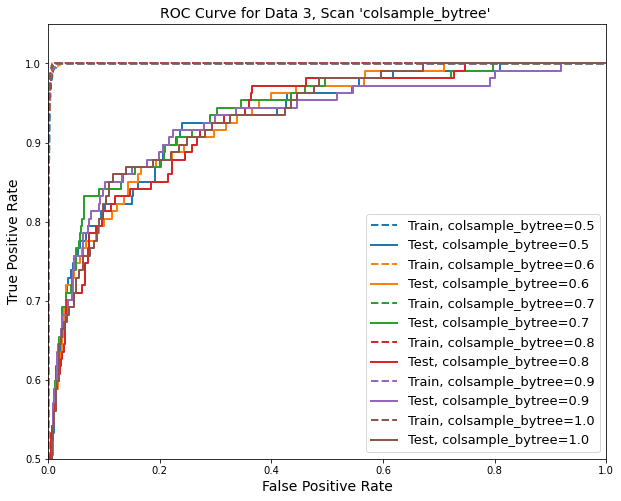

In [28]:
#Scan colsample_bytree

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100
}

scanParam = 'colsample_bytree'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments of colsample_bytree** 

* As colsample_bytree decrease, overfitting very sligtly decreases, almost not noticable.
* colsample_bytree=0.7 looks optimal chice.

,accuracy,precision,recall,f1,auc
Params,,,,,
subsample=0.5 Train,0.991,0.878,0.946,0.911,0.998
Test,0.965,0.702,0.551,0.618,0.910
subsample=0.6 Train,0.994,0.907,0.959,0.932,0.999
Test,0.969,0.773,0.542,0.637,0.926
subsample=0.7 Train,0.994,0.912,0.964,0.937,0.999
Test,0.966,0.733,0.514,0.604,0.917
subsample=0.8 Train,0.994,0.916,0.961,0.938,0.999
Test,0.967,0.738,0.551,0.631,0.924
subsample=0.9 Train,0.995,0.935,0.969,0.952,1.000


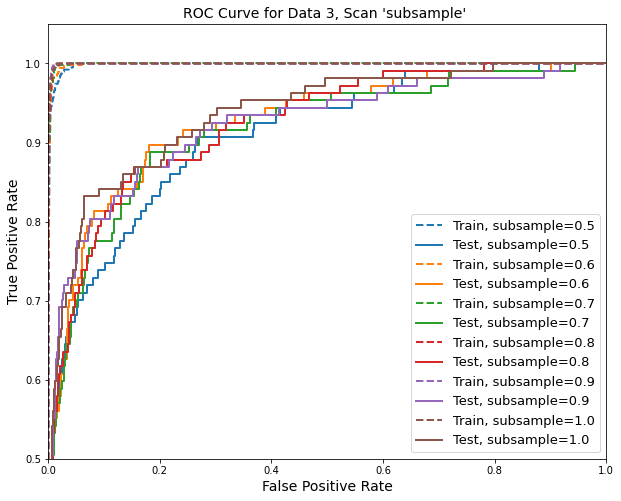

In [44]:
#Scan subsample

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7
}

scanParam = 'subsample'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments of subsample**

* The overfitting dependency on subsample is not clear.
* Best options are subsample=0.7 and 0.8.
* I choose to use subsample=0.8 

,accuracy,precision,recall,f1,auc
Params,,,,,
min_child_weight=1 Train,0.994,0.916,0.961,0.938,0.999
Test,0.967,0.738,0.551,0.631,0.924
min_child_weight=2 Train,0.994,0.922,0.951,0.937,0.999
Test,0.965,0.720,0.505,0.593,0.919
min_child_weight=3 Train,0.995,0.918,0.982,0.949,0.999
Test,0.966,0.706,0.561,0.625,0.929
min_child_weight=4 Train,0.993,0.900,0.956,0.928,0.999
Test,0.964,0.682,0.561,0.615,0.926


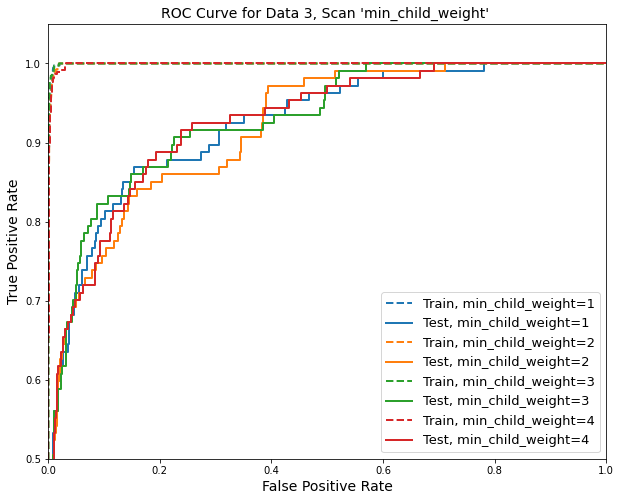

In [46]:
#Scan min_child_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8
}

scanParam = 'min_child_weight'

scanList = [1, 2, 3, 4]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments of min_child_weight**

* The overfitting dependency on min_child_weight is not clear.
* As the min_child_weight increases, the model performance decreases.
* I choose to use min_child_weight=1 

,accuracy,precision,recall,f1,auc
Params,,,,,
gamma=0 Train,0.994,0.916,0.961,0.938,0.999
Test,0.967,0.738,0.551,0.631,0.924
gamma=0.1 Train,0.994,0.916,0.961,0.938,0.999
Test,0.967,0.738,0.551,0.631,0.924
gamma=0.2 Train,0.995,0.922,0.969,0.945,0.999
Test,0.967,0.723,0.561,0.632,0.921
gamma=0.3 Train,0.995,0.930,0.964,0.947,0.999
Test,0.963,0.683,0.523,0.593,0.923
gamma=0.4 Train,0.995,0.930,0.964,0.947,0.999


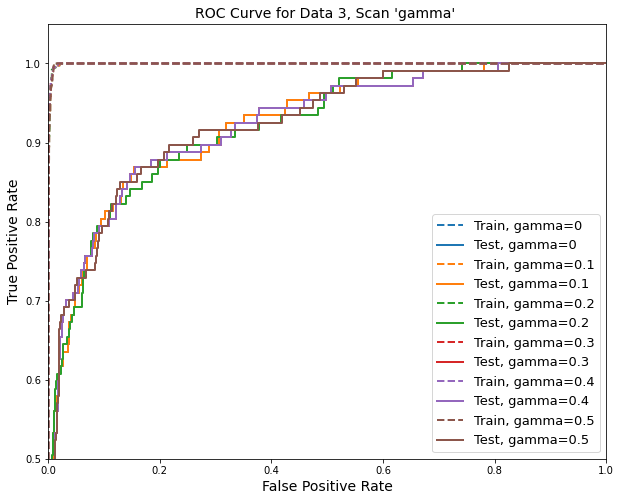

In [47]:
#Scan gamma

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8,
    'min_child_weight': 1,
}

scanParam = 'gamma'

scanList = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments on gamma**

* The overfitting dependency on gamma is not clear.
* As gamma increases, the model performance decreases.
* Best options are gamma=0 and 0.1
* I choose to use gamma=0 

,accuracy,precision,recall,f1,auc
Params,,,,,
learning_rate=0.05 Train,0.969,0.716,0.552,0.623,0.963
Test,0.961,0.671,0.477,0.557,0.920
learning_rate=0.1 Train,0.977,0.778,0.688,0.731,0.984
Test,0.963,0.671,0.533,0.594,0.923
learning_rate=0.15 Train,0.983,0.824,0.799,0.812,0.993
Test,0.966,0.725,0.542,0.620,0.933
learning_rate=0.2 Train,0.989,0.874,0.892,0.883,0.997
Test,0.964,0.686,0.551,0.611,0.924
learning_rate=0.25 Train,0.992,0.894,0.936,0.914,0.999


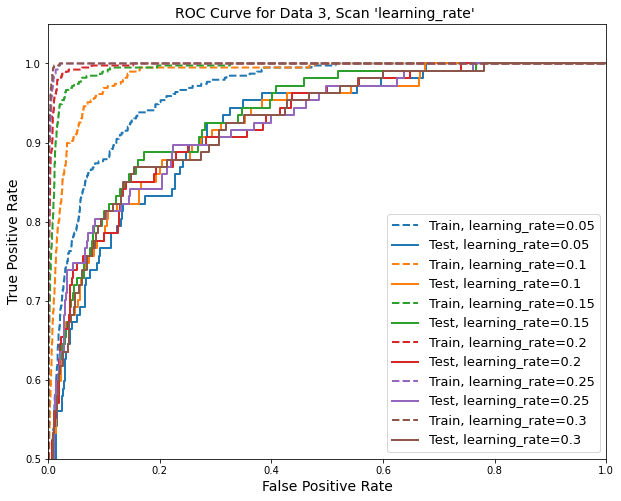

In [48]:
#Scan learning_rate

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8,
    'min_child_weight': 1,
    'gamma': 0
}

scanParam = 'learning_rate'

scanList = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments on learning_rate**

* The overfitting decreases as learning_rate decreases.
* However, model performance, especially precision, also affected.
* Best options are gamma=0.15 and 0.25
* I choose to use gamma=0.15

,accuracy,precision,recall,f1,auc
Params,,,,,
reg_lambda=0 Train,0.985,0.867,0.804,0.834,0.995
Test,0.966,0.731,0.533,0.616,0.925
reg_lambda=0.2 Train,0.985,0.848,0.820,0.834,0.994
Test,0.964,0.686,0.551,0.611,0.931
reg_lambda=0.4 Train,0.984,0.827,0.814,0.821,0.993
Test,0.968,0.735,0.570,0.642,0.927
reg_lambda=0.6 Train,0.984,0.827,0.814,0.821,0.993
Test,0.969,0.766,0.551,0.641,0.925
reg_lambda=0.8 Train,0.985,0.849,0.812,0.830,0.993


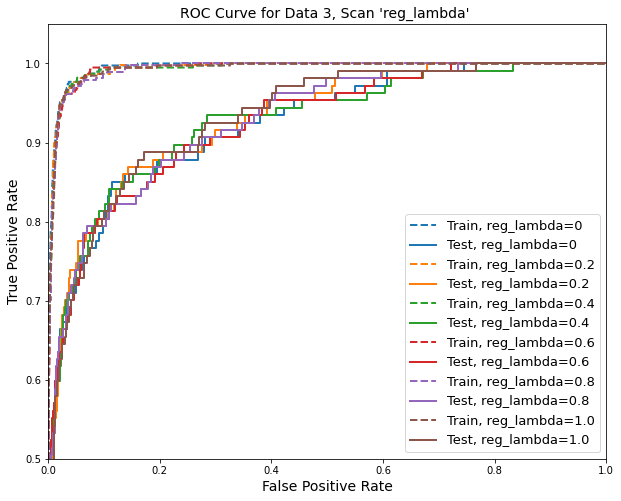

In [51]:
#Scan reg_lambda

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.15,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [0, .2, .4, .6, .8, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments on reg_lambda**

* L2 regularization parameter didn't effect the overfitting much.
* Best options is reg_lambda=0.6

,accuracy,precision,recall,f1,auc
Params,,,,,
reg_alpha=0 Train,0.985,0.867,0.804,0.834,0.995
Test,0.966,0.731,0.533,0.616,0.925
reg_alpha=0.2 Train,0.985,0.859,0.820,0.839,0.994
Test,0.963,0.670,0.551,0.605,0.929
reg_alpha=0.4 Train,0.984,0.845,0.799,0.821,0.993
Test,0.966,0.714,0.561,0.628,0.925
reg_alpha=0.6 Train,0.984,0.850,0.789,0.818,0.994
Test,0.966,0.725,0.542,0.620,0.934
reg_alpha=0.8 Train,0.984,0.843,0.804,0.823,0.993


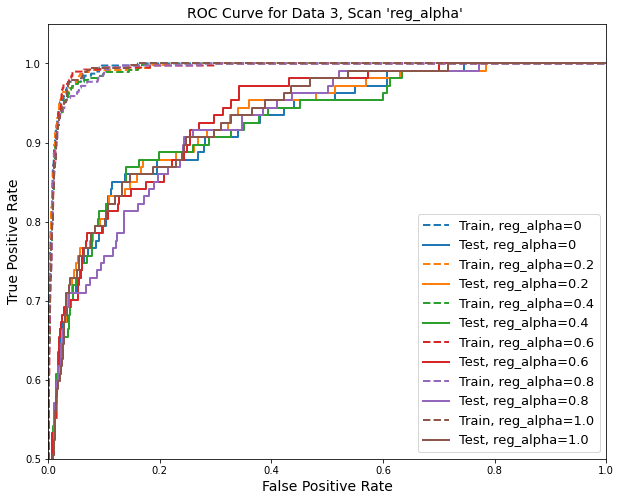

In [52]:
#Scan reg_alpha

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.15,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [0, .2, .4, .6, .8, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

**Comments on reg_alpha**

* L1 regularization parameter didn't effect the overfitting much.
* Best options is reg_apha=0.8

## Model with selected parameters (to decrease overfitting)

In [29]:
xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'n_estimators': 100,
    'colsample_bytree':0.7,
    'subsample': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.15,
    'reg_lambda': 0.6,
    'reg_alpha': 0  
}

model_2 = XGBClassifier(**xgbParams)
model_2.fit(X_train, y_train)

print('Data3, Model 2:\n')
print('Training Data:\n', classification_report(y_train, model_2.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_2.predict(X_test)))

model_2.save_model('saved_model_history/xgb_model_2.json')


Data3, Model 2:

Training Data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8014
           1       0.83      0.81      0.82       388

    accuracy                           0.98      8402
   macro avg       0.91      0.90      0.91      8402
weighted avg       0.98      0.98      0.98      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1994
           1       0.77      0.55      0.64       107

    accuracy                           0.97      2101
   macro avg       0.87      0.77      0.81      2101
weighted avg       0.97      0.97      0.97      2101



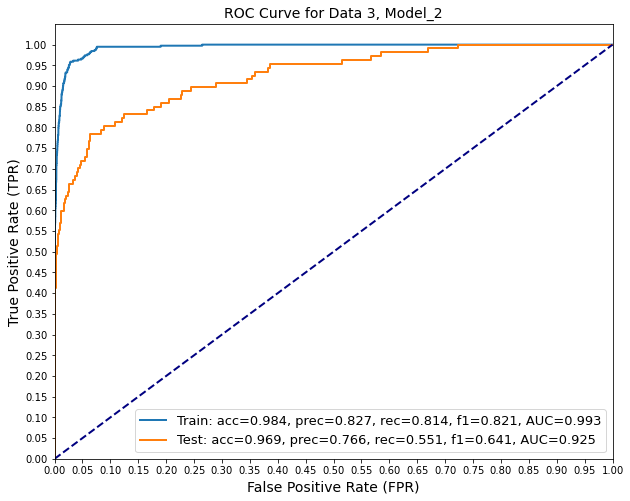

In [27]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, xgbParams, 'Model_2')

**Comments**

* Compared to Model 1, overfitting decreased. The training results do not show perfect value anymore.
* However, the model performance also decreased a bit.
* In testing data:
    * Precision drops from 0.95 to to 0.77
    * Accuracy stays around 0.97
    * f1 drops from 0.67 to 0.64
    * AUC slightly drops from 0.94 to 0.93
    